In [6]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
params = {'image.cmap': "Set2"}
matplotlib.rcParams.update(params)
import numpy as np
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def get_q(reader,qname):
    u = reader.readData(qname);
    u = np.squeeze(u);
    ubar = np.mean(np.mean(u,axis=1),axis=0);
    uprime2D = np.squeeze(u-ubar)
    return u,ubar,uprime2D

def get_qf(reader,qname):#Favre average
    r,u = reader.readData(('rho',qname));
    u = np.squeeze(u);
    r = np.squeeze(r);  
    rbar   = np.mean(np.mean(r))
    utilde = np.mean(np.mean(r*u))/rbar;
    upprime2D = np.squeeze(u-utilde)
    return u,utilde,upprime2D

def autocorr(uprime2D):
    uhat = np.fft.fftshift(np.fft.fft2(uprime2D))
    R_fft = np.square(np.abs(uhat))
    R = np.abs(np.fft.fftshift(np.fft.ifft2(R_fft)))
    return R/R.max()

def plot_autocorr(reader,plist,yslice,savename=''):
    reader.sub_domain = (0,ic,0), (reader.domain_size[0]-1, ic, reader.domain_size[2]-1)
    
    nq = len(plist)
    fig, ax = plt.subplots(1,nq, figsize=(12,nq), dpi=200)

    levels = np.arange(0.,1.,0.1)
    for i,primitive in enumerate(plist):
        u,U,uprime2D = get_qf(reader,primitive)
        Rii = autocorr(uprime2D)
        cont = ax[i].contour(z,x,Rii,levels=levels)
        ax[i].clabel(cont, inline=1, fontsize=0.75*fs)
        ax[i].set_xticks([])
        ax[i].set_yticks([]) 
        ax[i].set_title(primitive)
        ax[i].set_xlabel('z')
        ax[i].set_ylabel('x')
        i+=1

    # set the overall title and save
    # fig.suptitle('Time: {}'.format(np.around(reader.time,-1)),size=fs,y=0.95)
    if savename:
        fig.savefig(savename, dpi=200,bbox_inches='tight')
        plt.close(fig)
        print "Saved plot to ",savename
    else: 
        print(directory)
        print("Time: {}".format(reader.time))
        plt.show()

In [15]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/'

filename_prefix = directory+'shearlayer_'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(Ly/2.,-Ly/2.,Ny)
x = np.linspace(0,Lx,int(Nx))
z = np.linspace(0,Lz,int(Nz))

reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
kx = [2.0*np.pi/float(Lx)*w for w in range(0,int(Nx/2))]; kx = np.array(kx)
kz = [2.0*np.pi/float(Lz)*w for w in range(0,int(Nz/2))]; kz = np.array(kz)

steps = sorted(reader.steps)
print("Steps: {}".format(reader.steps))

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
Steps: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)


(1.166205943331029, 710)
/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/
Time: 120.0


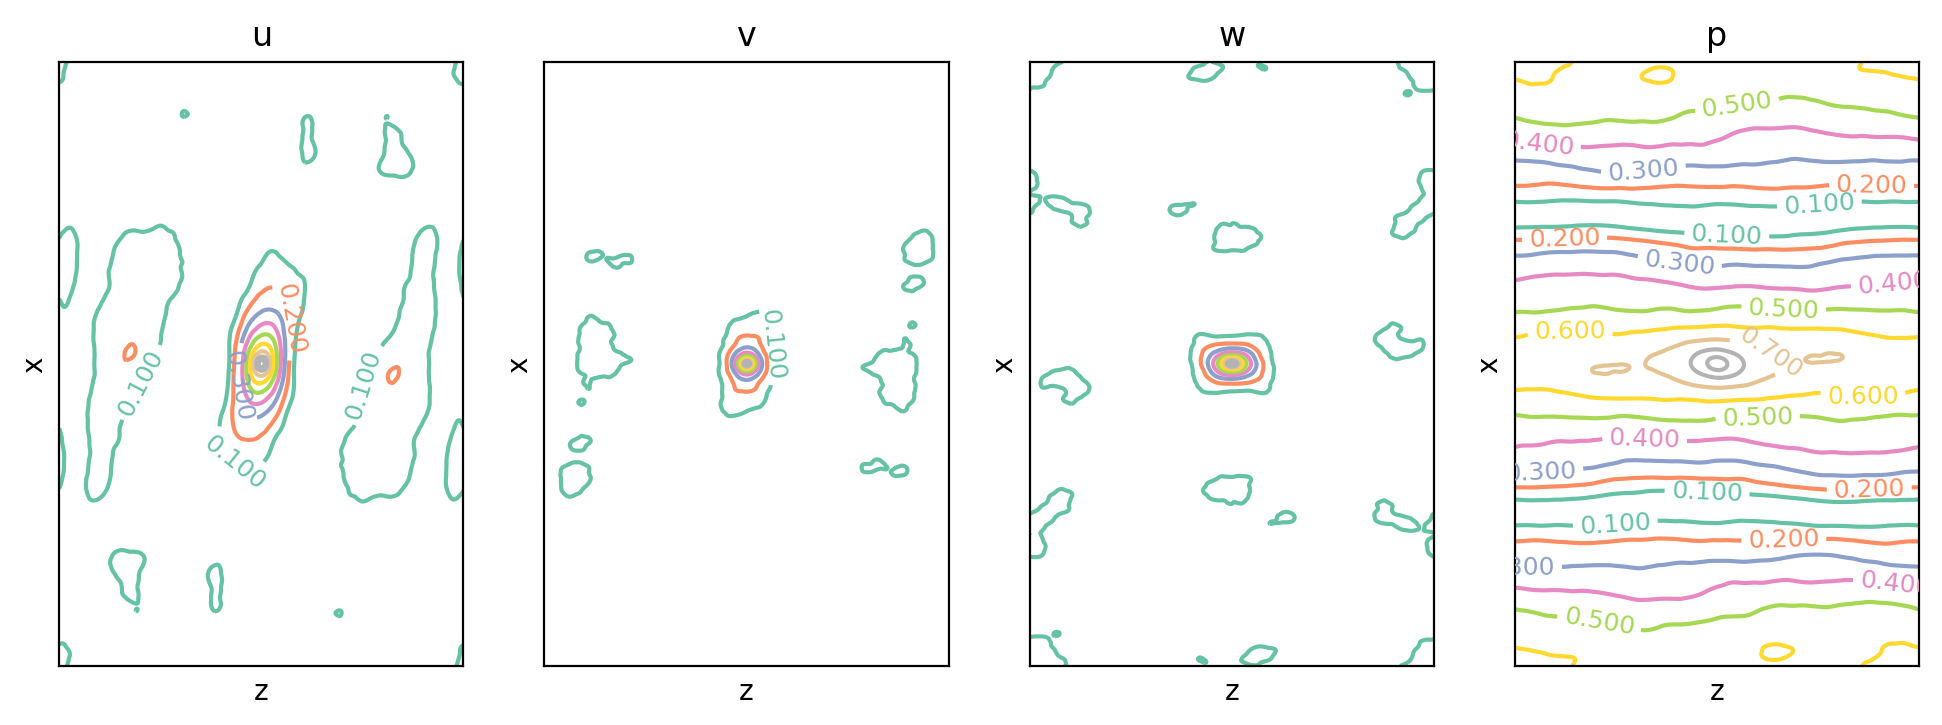

In [5]:
# Autocorrelation
      
# Get the centerline for the last step
step = max(steps)
ic,yc = get_centerline(directory,y,step)
print(yc,ic)

reader.step = step        
plot_autocorr(reader,('u','v','w','p'),ic)


In [3]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    reader = por.PadeopsReader(directory+'/shearlayer_', periodic_dimensions=(True,False,True))
    steps = reader.steps
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    x = np.linspace(0,Lx,int(Nx))
    z = np.linspace(0,Lz,int(Nz))

    step = max(reader.steps)
    reader.step = step
    ic,yc = get_centerline(directory,y,step)
    plot_autocorr(reader,('u','v','w','p'),ic,savename=directory+'/img/autocorr.png')
    
print('Done')

Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512//img/autocorr.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512//img/autocorr.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512//img/autocorr.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512//img/autocorr.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512//img/autocorr.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512//img/autocorr.png
Done


{0: array([1.15185688e-06, 7.13479744e-07, 1.55115662e-06, 3.11516357e-06,
        2.24577801e-05, 7.17615979e-06, 1.94115743e-06, 2.23814924e-06,
        1.74759898e-06, 2.18153718e-06, 2.06660289e-06, 1.42058546e-06,
        1.17922542e-06, 1.04906419e-06, 8.83735646e-07, 1.20122390e-06,
        6.38222924e-07, 5.67313916e-07, 5.82806416e-07, 7.38977577e-07,
        5.68118018e-07, 3.64252161e-07, 3.81340961e-07, 3.73669635e-07,
        3.25371155e-07, 3.34489143e-07, 2.67096954e-07, 2.74127166e-07,
        2.77063555e-07, 2.33737507e-07, 2.11384398e-07, 1.97194826e-07,
        2.28064995e-07, 2.10090682e-07, 1.70678134e-07, 1.54482697e-07,
        1.51905163e-07, 1.29414501e-07, 1.39266482e-07, 1.20689429e-07,
        1.27013342e-07, 1.04349624e-07, 9.48808313e-08, 1.06664360e-07,
        1.06620998e-07, 7.63076885e-08, 8.23787290e-08, 8.19986221e-08,
        6.74630196e-08, 6.09354180e-08, 7.81388598e-08, 7.85901061e-08,
        5.08366718e-08, 5.91608769e-08, 5.59234436e-08, 4.893

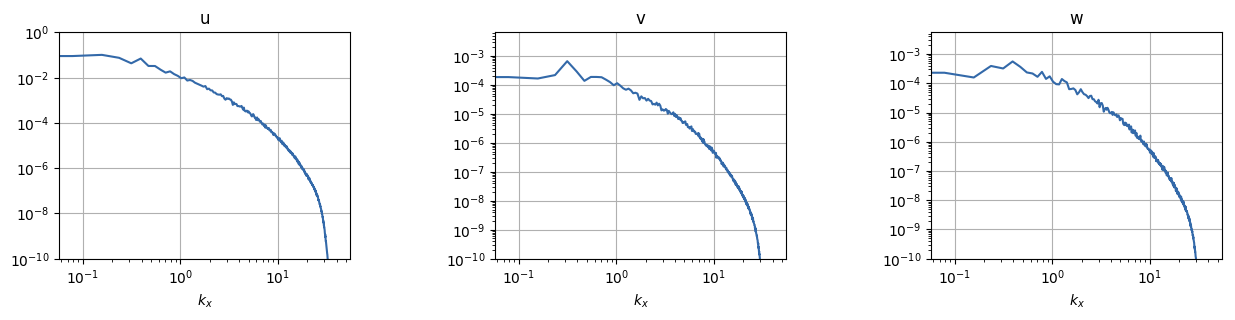

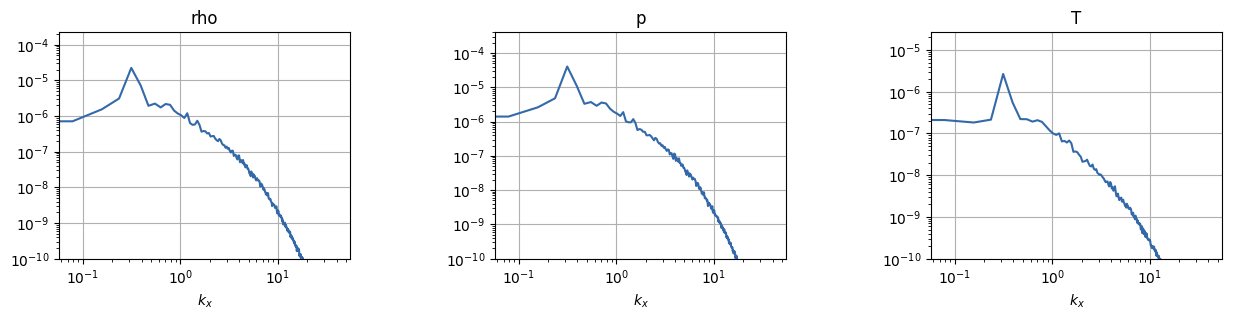

In [17]:
# Energy spectra
def Eii(uprime,k_axis):
    uhat = 1./Nx * np.fft.fft(uprime,axis=k_axis)
    return 2.* np.mean( np.square(np.abs(uhat)),1)

color1=[51./255, 105./255, 169./255]
color2=[200./255, 90./255, 90./255]
def energy_spectra(reader,plist,yslice):
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
    idx = range(int(Nx)/2)
    fig, ax = plt.subplots(1,3, figsize=(15,3), dpi=100)
    Re = 1000
    nu = 1./Re
    
    mat = {}
    for i,primitive in enumerate(plist):
        u,U,uprime2D = get_qf(reader,primitive)
        Espec = Eii(uprime2D,k_axis=0)
        E = Espec[idx]
        D = 2*nu*E*kx**2;
        ax[i].set_xlabel('$k_x$')
        ax[i].set_title(primitive)
        ax[i].loglog(kx,E,label='E(k)',color=color1)
        ax[i].grid(True)
        #ax2 = ax[i].twinx()
        #ax2.loglog(kx,D,label='D(k)',color=color2)
        #ax2.tick_params(axis='y', labelcolor=color2)
        plt.subplots_adjust(wspace=0.5,hspace=0.1)
        mat[i]=E
        ax[i].set_ylim([1e-10,10*np.amax(Espec)])

    return mat

step = 8#max(steps)
yslice = Ny/2
energy_spectra(reader,['u','v','w'],yslice)
energy_spectra(reader,['rho','p','T'],yslice)

In [1]:
yslice = Ny/2
reader.step = max(steps)
print("Time: {}".format(reader.time))
mat = energy_spectra(reader,('rho','u','v'),ic)
ax[0].set_ylim([1e-4,1e-10])

NameError: name 'Ny' is not defined

In [34]:
for i in range(Nx/2):
    print('{} {} {} {}'.format(kx[i],mat[0][i],mat[1][i],mat[2][i]))

0.0 1.53783020482e-06 0.00166231419121 0.000181579753912
0.0418879020479 1.3398295509e-06 0.00148090777838 0.000283130249545
0.0837758040957 6.78169961856e-06 0.00110828568051 0.000333144161099
0.125663706144 3.38918868595e-06 0.000582824535828 0.000224124054333
0.167551608191 2.36389590845e-06 0.000609405718823 0.0002869264439
0.209439510239 2.07381843624e-06 0.00049965256709 0.000172462847848
0.251327412287 7.39977806564e-07 0.00034741591969 0.00017156702319
0.293215314335 8.92145034772e-07 0.000178753225287 0.000136785430363
0.335103216383 1.07786518179e-06 0.00017102586878 0.000117689985237
0.376991118431 7.47935596733e-07 0.000135305384169 9.32589282151e-05
0.418879020479 7.43490726166e-07 8.96444317769e-05 0.000106499922016
0.460766922527 4.32378385346e-07 0.000111670294833 7.4565330257e-05
0.502654824574 5.41833173691e-07 8.56161149664e-05 9.0975065613e-05
0.544542726622 5.15350576221e-07 8.922680182e-05 7.40096792954e-05
0.58643062867 5.92735149581e-07 6.72123280442e-05 9.27503

Time: 1850.0


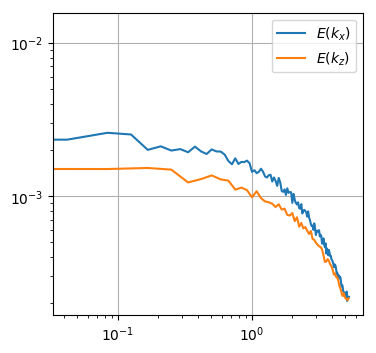

In [63]:
# Enstrophy spectrum at midplane. See enstrophy.py
def plot_enstrophy_spectra(step):
    reader.step = step;
    print("Time: {}".format(reader.time))

    fig = plt.figure(figsize=(4,4), dpi=100)
    dat = np.fromfile(filename_prefix + "%04d"%step + "_enstrophy_spectrum_x.dat",dtype=float,count=-1,sep='\n')
    plt.loglog(kx,dat[range(Nx/2)],label='$E(k_x)$')
    dat = np.fromfile(filename_prefix + "%04d"%step + "_enstrophy_spectrum_z.dat",dtype=float,count=-1,sep='\n')
    plt.loglog(kz,dat[range(Nz/2)],label='$E(k_z)$')
    plt.legend()
    plt.grid(True)

plot_enstrophy_spectra(step=37)


In [33]:
# Autocorrelation length in y using xy slice
reader.sub_domain = (0,0,0), (reader.domain_size[0]-1, reader.domain_size[1]-1, reader.domain_size[2]-1)
x, y, z = reader.readCoordinates()
yplot = np.squeeze(y[0,:,0])

reader.step = 4
print("Time: {}".format(reader.time))

# Get fluctuations
u = reader.readData('u')
u = np.squeeze(np.array(u))
U = np.mean(np.mean(u,axis=zdir),axis=xdir)
up = np.zeros(np.shape(u))
for i in range(Ny-1):
    up[:,i,:] = u[:,i,:] - U[i]

    
#plt.imshow(up[:,:,1])

Time: 400.0
